In [1]:
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from polygon import RasLoss, SoftPolygon
from Loader_17 import DAVIS_Rawset, normalize
import logging
import json
import os
from tqdm import tqdm
from deform_video import (
    DAVIS_withPointRandom,
    DeformLightVideo,
    VideoInferer,
    DeformLightVideoPos,
    IMGPositionEmbeddingSine,
    DeformableTransformerExtraDecoder,
    DeformableTransformerExtraDecoderLayer,
    RefineLightPos,
)
from deform_model import get_batch_average_bou_iou, DeformLearnImage
import matplotlib.pyplot as plt
import regex as re
from preprocess_utensils import Boundary_points
import torch.nn as nn
from torch.nn.init import xavier_uniform_
from deform_model import (
    _get_clones,
    _get_activation_fn,
    get_valid_ratio,
    PositionalEncoding,
    DeformableTransformerEncoderLayer,
    DeformableTransformerDecoderLayer,
    DeformableTransformerEncoder,
    DeformableTransformerDecoder,
    MLP,
    get_bounding_box,
    add_mid_points,
    get_batch_average_bou_iou,
)
from einops import rearrange
import torch.nn.functional as F
import numpy as np

In [2]:
val_raw_set = DAVIS_Rawset(is_train=False)

In [ ]:
val_dataset = DAVIS_withPointRandom(
    val_raw_set,
    is_train=False,
    point_num=64,
)
gt_rasterizer = SoftPolygon(1, "hard_mask").cuda()
val_inferer = VideoInferer(val_dataset, gt_rasterizer)

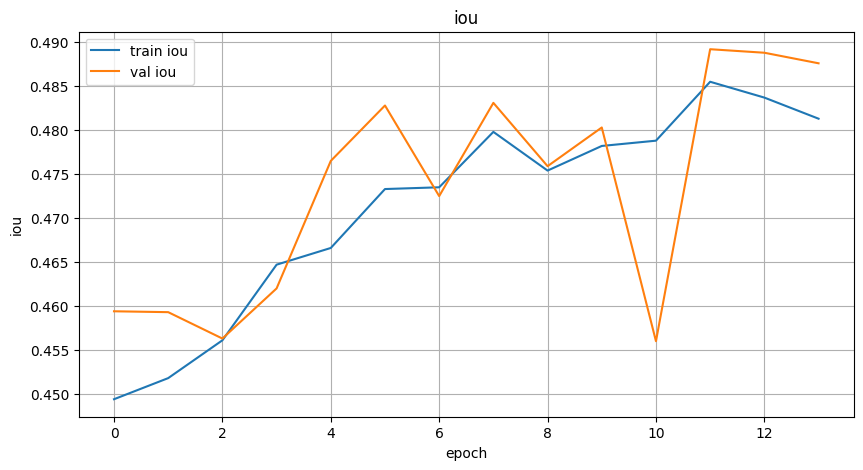

In [4]:
# model_name = "coco_def_light_more"
model_name = "coco_refine_light"
# create the log directory
log_dir = f"./log/{model_name}"
log_path = f"{log_dir}/{model_name}.log"
model_path = f"./model/{model_name}_best.pth"
# load the log file
# load the log
with open(log_path, "r") as f:
    logs = f.readlines()
loss_dict = {}
iou_train_dict = {}
iou_val_dict = {}
# get the loss and iou using regex
for log in logs:
    # get the epoch
    epoch = re.search(r"Epoch (\d+)", log)
    if epoch is not None:
        epoch = int(epoch.group(1))
        # get the loss
        loss = re.search(r"train loss: ([\d.]+)", log)
        if loss is not None:
            loss_dict[epoch] = float(loss.group(1))
        # get the train iou
        iou = re.search(r"train iou: ([\d.]+)", log)
        if iou is not None:
            iou_train_dict[epoch] = float(iou.group(1))
        # get the val iou
        iou = re.search(r"val iou: ([\d.]+)", log)
        if iou is not None:
            iou_val_dict[epoch] = float(iou.group(1))
# plot the loss and iou
plt.figure(figsize=(10, 5))
# plt.subplot(2, 1, 1)
# plt.grid()
# plt.plot(loss_dict.keys(), loss_dict.values())
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.title("train loss")
# plt.subplot(2, 1, 2)
plt.grid()
plt.plot(iou_train_dict.keys(), iou_train_dict.values(), label="train iou")
plt.plot(iou_val_dict.keys(), iou_val_dict.values(), label="val iou")
plt.xlabel("epoch")
plt.ylabel("iou")
plt.title("iou")
plt.legend()
plt.show()

In [5]:
# model = DeformLightVideoPos(offset_limit=56).cuda()
model = RefineLightPos(offset_limit=56).cuda()
model.load_state_dict(torch.load(model_path))

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/tmp/ipykernel_2377068/3331265502.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please 

<All keys matched successfully>

In [6]:
val_inferer.infer_all_videos(model, use_tqdm=True)

  0%|                                                                                                                                                       | 0/57 [00:00<?, ?it/s]/work3/s232248/miniconda3/envs/rd/lib/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [11:33<00:00, 12.17s/it]


In [7]:
val_inferer.compute_all_videos_iou()

0.16572416559592776

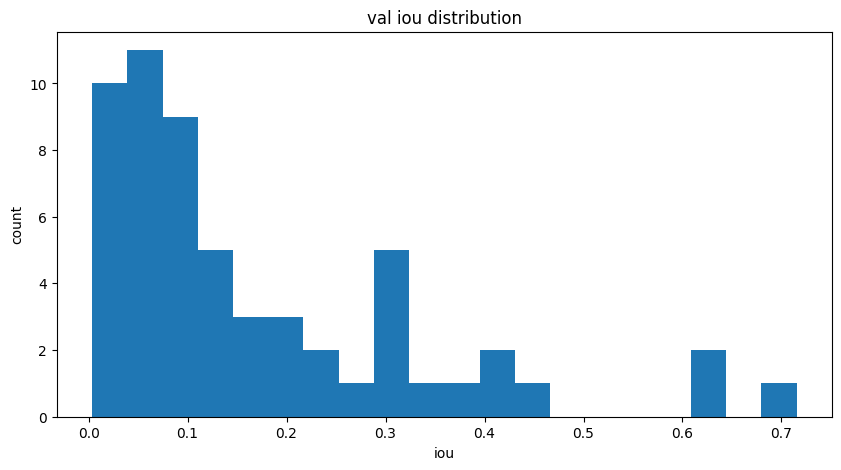

In [8]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 9, 13, 50, 54]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

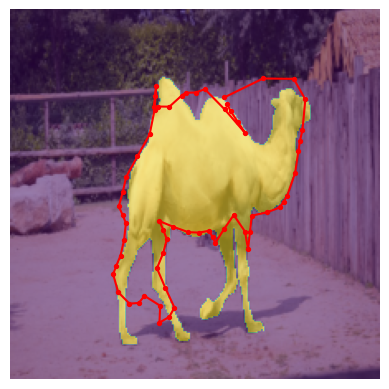

In [9]:
video_idx = 6
frame_idx = 5
img, gt_mask, gt_bou = val_dataset.raw_data_set[video_idx][frame_idx]
infer_result = val_inferer.infer_results[video_idx][frame_idx]
infer_bou, infer_mask, infer_iou = infer_result
np_bous = infer_bou.detach().cpu().numpy()
np_bou = np_bous[0]
np_bou.shape
plt.imshow(normalize(img).permute(1, 2, 0))
plt.plot(np_bou[:, 0], np_bou[:, 1], "r")
plt.scatter(np_bou[:, 0], np_bou[:, 1], c="r", s=8)
plt.imshow(gt_mask, alpha=0.5)
plt.axis("off")
plt.show()

## Wrap the image model

In [10]:
img_model = DeformLearnImage().cuda()
img_model_path = "./model/deform_img_davis_best.pth"
img_model.load_state_dict(torch.load(img_model_path))


Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main
/tmp/ipykernel_2377068/2035461767.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please 

<All keys matched successfully>

In [11]:
class WrapImgModel(nn.Module):
    def __init__(self, img_model):
        super(WrapImgModel, self).__init__()
        self.img_model = img_model

    def forward(
        self,
        fir_img: torch.Tensor,
        fir_bou: torch.Tensor,
        pre_img: torch.Tensor,
        pre_bou: torch.Tensor,
        pre_sgm: torch.Tensor,
        cur_img: torch.Tensor,
    ):
        self.img_model.eval()
        return self.img_model(cur_img, pre_sgm)

In [12]:
wrap_img_model = WrapImgModel(img_model).cuda()

In [13]:
val_inferer.infer_all_videos(wrap_img_model, use_tqdm=True)

  0%|                                                                                                                                                       | 0/57 [00:00<?, ?it/s]

  2%|██▌                                                                                                                                            | 1/57 [00:06<05:42,  6.12s/it]


KeyboardInterrupt: 

In [23]:
val_inferer.compute_all_videos_iou()

0.15361139390650252

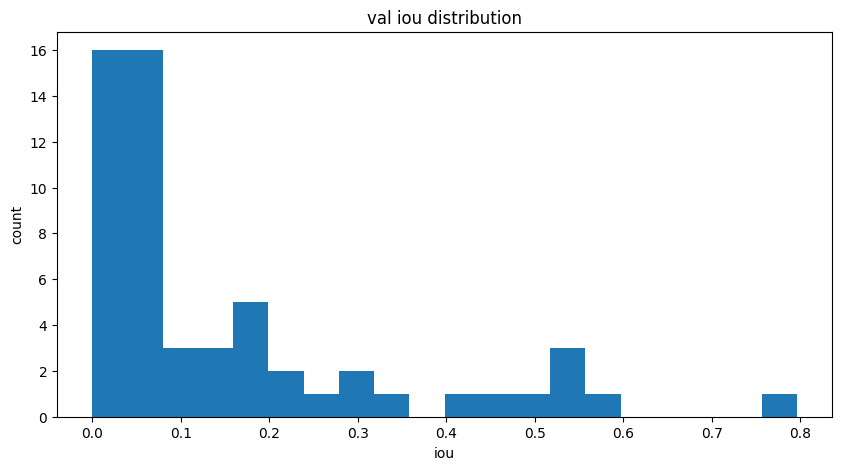

In [24]:
ious = val_inferer.video_ious
# plot the distribution of iou
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=20)
plt.xlabel("iou")
plt.ylabel("count")
plt.title("val iou distribution")
plt.show()

In [ ]:
val_check_idxs = [2, 9, 13, 50, 54]
for idx in val_check_idxs:
    val_inferer.show_video_results(idx)

## New Refine Model

In [98]:
bou_simplifier = Boundary_points(np_bou)
sim_bou_np = bou_simplifier.simplify_to_num(16)

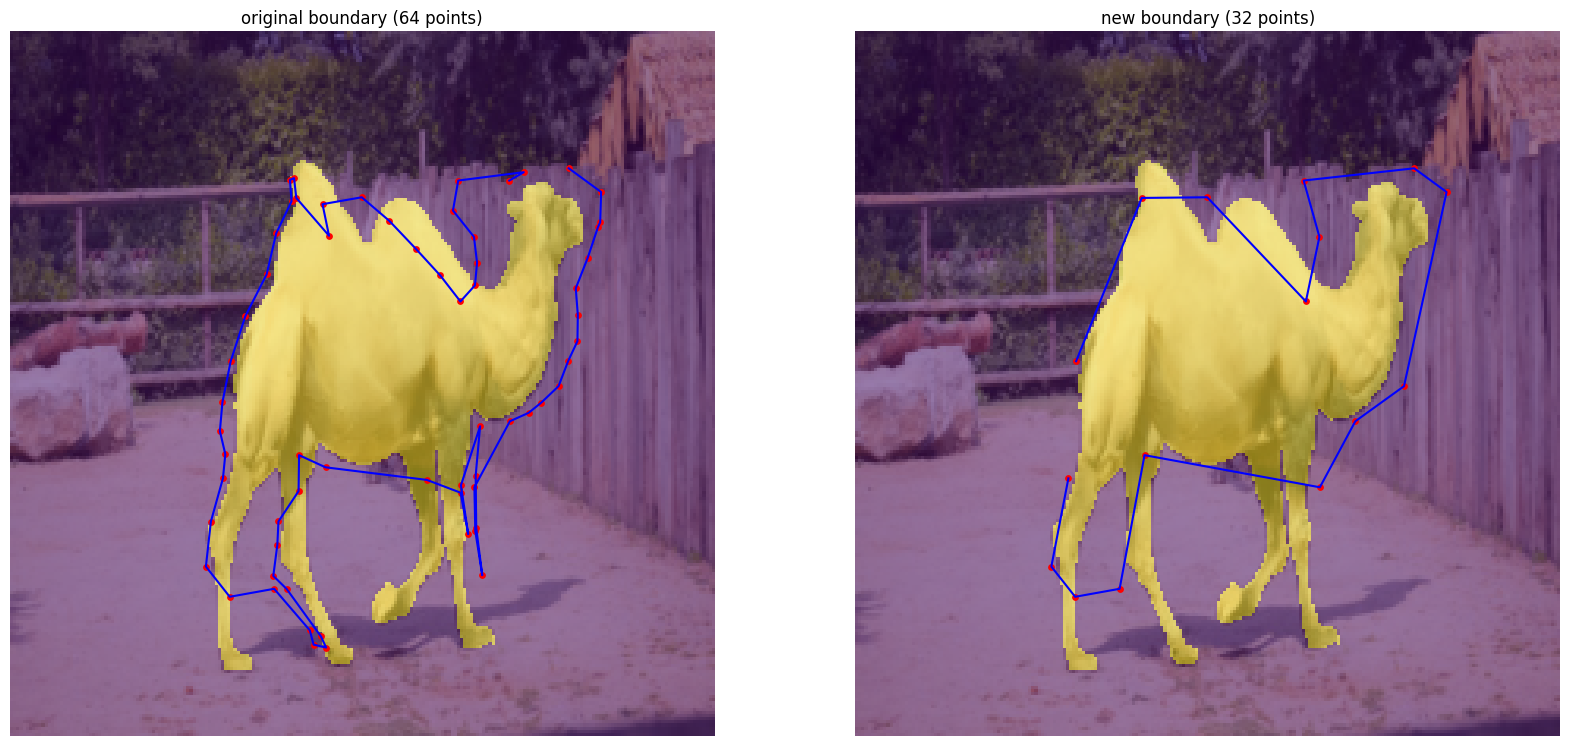

In [99]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(normalize(img).permute(1, 2, 0))
plt.plot(np_bou[:, 0], np_bou[:, 1], "b")
plt.scatter(np_bou[:, 0], np_bou[:, 1], c="r", s=15)
plt.imshow(gt_mask, alpha=0.5)
plt.axis("off")
plt.title("original boundary (64 points)")
plt.subplot(1, 2, 2)
plt.imshow(normalize(img).permute(1, 2, 0))
plt.plot(sim_bou_np[:, 0], sim_bou_np[:, 1], "b")
plt.scatter(sim_bou_np[:, 0], sim_bou_np[:, 1], c="r", s=15)
plt.imshow(gt_mask, alpha=0.5)
plt.title("new boundary (32 points)")
plt.axis("off")
plt.show()

In [ ]:
def simplify_bou_batch(bous, num_points):
    bous = bous.detach().cpu().numpy()
    bous = [Boundary_points(bou).simplify_to_num(num_points) for bou in bous]
    return torch.tensor(bous).cuda().float()

In [134]:
class RefineLightPos(nn.Module):
    def __init__(
        self,
        layer_num=1,
        head_num=6,
        medium_level_size=[14, 28, 56, 112],
        offset_limit=10,
        n_points=4,
        freeze_backbone=True,
    ) -> None:
        super(RefineLightPos, self).__init__()
        mem_point_num = 64
        self.offset_limit = offset_limit
        self.n_points = n_points
        self.point_num = mem_point_num
        self.medium_level_size = medium_level_size
        self.featup = torch.hub.load(
            "mhamilton723/FeatUp",
            "dino16",
            use_norm=True,
        )
        if freeze_backbone:
            for param in self.featup.parameters():
                param.requires_grad = False
        d_model = 384
        d_ffn = 1024
        n_levels = len(medium_level_size) + 1
        self.pos_enoc = PositionalEncoding(d_model)
        self.level_pos = nn.Embedding(n_levels, d_model)
        self.img_pos = IMGPositionEmbeddingSine(d_model=d_model)
        xavier_uniform_(self.level_pos.weight)

        enc_layer = DeformableTransformerEncoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )
        dec_layer = DeformableTransformerDecoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )

        self.first_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.first_query_embed.weight)
        self.first_layer_norm = nn.LayerNorm(d_model)
        self.fir_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        self.fir_dec = DeformableTransformerDecoder(
            dec_layer,
            num_layers=layer_num,
        )
        self.previous_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.previous_query_embed.weight)
        self.previous_layer_norm = nn.LayerNorm(d_model)
        self.pre_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        self.pre_dec = DeformableTransformerDecoder(
            dec_layer,
            num_layers=layer_num,
        )
        self.extra_layer_norm = nn.LayerNorm(d_model)

        self.cur_enc = DeformableTransformerEncoder(
            enc_layer,
            num_layers=layer_num,
        )
        self.current_layer_norm = nn.LayerNorm(d_model)
        self.cur_64_query_embed = nn.Embedding(mem_point_num, d_model)
        xavier_uniform_(self.cur_64_query_embed.weight)
        extra_dec_layer = DeformableTransformerExtraDecoderLayer(
            d_model=d_model,
            d_ffn=d_ffn,
            n_levels=n_levels,
            n_heads=head_num,
            n_points=n_points,
        )
        self.cur_64_dec = DeformableTransformerExtraDecoder(
            extra_dec_layer,
            num_layers=layer_num,
        )
        xy_fc = MLP(d_model, d_model, 2, 3)
        self.xy_fcs = _get_clones(xy_fc, 2)

        self.cur_32_query_embed = nn.Embedding(mem_point_num // 2, d_model)
        xavier_uniform_(self.cur_32_query_embed.weight)
        self.cur_32_layer_norm = nn.LayerNorm(d_model)
        self.cur_32_dec = DeformableTransformerExtraDecoder(
            extra_dec_layer,
            num_layers=layer_num,
        )

    def forward(
        self,
        fir_img: torch.Tensor,
        fir_bou: torch.Tensor,
        pre_img: torch.Tensor,
        pre_bou: torch.Tensor,
        pre_sgm: torch.Tensor,
        cur_img: torch.Tensor,
    ):
        fir_bou = fir_bou / 224
        pre_bou = pre_bou / 224
        (
            fir_img_srcs_flatten,
            fir_spatial_shapes,
            fir_level_start_index,
            fir_valid_ratios,
        ) = self._get_enced_img_scrs(
            fir_img,
            self.fir_enc,
            self.first_layer_norm,
        )
        (
            pre_img_srcs_flatten,
            pre_spatial_shapes,
            pre_level_start_index,
            pre_valid_ratios,
        ) = self._get_enced_img_scrs(
            pre_img,
            self.pre_enc,
            self.previous_layer_norm,
        )
        (
            cur_img_srcs_flatten,
            cur_spatial_shapes,
            cur_level_start_index,
            cur_valid_ratios,
        ) = self._get_enced_img_scrs(
            cur_img,
            self.cur_enc,
            self.current_layer_norm,
        )

        B, S, C = fir_img_srcs_flatten.shape
        first_queries = (
            self.first_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        first_memory, _ = self.fir_dec(
            first_queries,
            fir_bou,
            fir_img_srcs_flatten,
            fir_spatial_shapes,
            fir_level_start_index,
            fir_valid_ratios,
        )
        previous_queries = (
            self.previous_query_embed.weight.unsqueeze(0).repeat(B, 1, 1).cuda()
        )
        previous_memory, _ = self.pre_dec(
            previous_queries,
            pre_bou,
            pre_img_srcs_flatten,
            pre_spatial_shapes,
            pre_level_start_index,
            pre_valid_ratios,
        )
        extra_memory = torch.cat([first_memory, previous_memory], 1)
        extra_memory = self.extra_layer_norm(extra_memory)
        extra_memory = self.pos_enoc(extra_memory)

        results = []
        cur_bou = pre_bou
        results.append(
            self._get_result(
                self.cur_64_query_embed,
                self.cur_64_dec,
                cur_bou,
                cur_img_srcs_flatten,
                cur_spatial_shapes,
                cur_level_start_index,
                cur_valid_ratios,
                extra_memory,
                self.xy_fcs[0],
            )
        )
        cur_bou = self._simplify_bou_batch(cur_bou, 32)
        results.append(
            self._get_result(
                self.cur_32_query_embed,
                self.cur_32_dec,
                cur_bou,
                cur_img_srcs_flatten,
                cur_spatial_shapes,
                cur_level_start_index,
                cur_valid_ratios,
                extra_memory,
                self.xy_fcs[1],
            )
        )
        cur_bou = add_mid_points(cur_bou)
        results.append(
            self._get_result(
                self.cur_64_query_embed,
                self.cur_64_dec,
                cur_bou,
                cur_img_srcs_flatten,
                cur_spatial_shapes,
                cur_level_start_index,
                cur_valid_ratios,
                extra_memory,
                self.xy_fcs[0],
            )
        )
        results = [result * 224 for result in results]
        if self.training:
            return results
        else:
            return results[-1].clamp(0, 223)

    def _get_result(
        self,
        query_embed: nn.Embedding,
        dec: DeformableTransformerExtraDecoder,
        cur_bou: torch.Tensor,
        img_srcs_flatten: torch.Tensor,
        spatial_shapes: torch.Tensor,
        level_start_index: torch.Tensor,
        valid_ratios: torch.Tensor,
        extra_memory: torch.Tensor,
        xy_fc: MLP,
    ):
        queries = query_embed.weight.unsqueeze(0).repeat(cur_bou.shape[0], 1, 1).cuda()
        decode_output, _ = dec(
            queries,
            cur_bou,
            img_srcs_flatten,
            spatial_shapes,
            level_start_index,
            valid_ratios,
            extra_memory,
        )
        xy_offset = xy_fc(decode_output)
        xy_offset = (xy_offset.sigmoid() - 0.5) * self.offset_limit / 224
        result = cur_bou + xy_offset

        return result

    def _get_img_scrs(self, img: torch.Tensor, layernorm: nn.LayerNorm):
        feats = self.featup(img)
        srcs = []
        padding_masks = []
        pos_embeds = []
        for low_res in self.medium_level_size:
            srcs.append(
                F.interpolate(
                    feats,
                    size=(low_res, low_res),
                    mode="bilinear",
                ),
            )
        srcs.append(feats)
        for src in srcs:
            padding_masks.append(torch.zeros_like(src[:, 0:1, :, :]).squeeze(1).bool())
            pos_embeds.append(self.img_pos(src, padding_masks[-1]))
        src_flatten = []
        spatial_shapes = []
        pos_embed_flatten = []
        # for src in srcs:
        # for src, pos in zip(srcs, pos_embeds):
        for lvl, (src, pos) in enumerate(zip(srcs, pos_embeds)):
            src_flatten.append(
                rearrange(src, "b c h w -> b (h w) c"),
            )
            spatial_shapes.append(src.shape[-2:])
            pos = rearrange(pos, "b c h w -> b (h w) c")
            pos = self.level_pos.weight[lvl].view(1, 1, -1) + pos
            pos_embed_flatten.append(pos)

        level_start_index = torch.cat(
            (
                torch.tensor([0]),
                torch.cumsum(
                    torch.tensor([x.shape[1] for x in src_flatten]),
                    0,
                )[:-1],
            )
        ).cuda()
        src_flatten = torch.cat(src_flatten, 1).cuda()
        pos_embed_flatten = torch.cat(pos_embed_flatten, 1).cuda()
        valid_ratios = torch.stack(
            [get_valid_ratio(mask) for mask in padding_masks],
            1,
        ).cuda()
        spatial_shapes = torch.as_tensor(
            spatial_shapes,
            dtype=torch.long,
            device=src_flatten.device,
        )
        src_flatten = layernorm(src_flatten)
        # src_flatten = self.pos_enoc(src_flatten)

        return (
            src_flatten,
            spatial_shapes,
            level_start_index,
            valid_ratios,
            pos_embed_flatten,
        )

    def _get_enced_img_scrs(
        self,
        img: torch.Tensor,
        encoder: DeformableTransformerEncoder,
        layernorm: nn.LayerNorm,
    ):
        (
            src_flatten,
            spatial_shapes,
            level_start_index,
            valid_ratios,
            pos_embed_flatten,
        ) = self._get_img_scrs(img, layernorm)
        src_flatten += pos_embed_flatten
        src_flatten = encoder(
            src=src_flatten,
            spatial_shapes=spatial_shapes,
            level_start_index=level_start_index,
            valid_ratios=valid_ratios,
        )
        return src_flatten, spatial_shapes, level_start_index, valid_ratios

    def _simplify_bou_batch(self, bous, num_points):
        bous = bous.detach().cpu().numpy()
        bous = [Boundary_points(bou).simplify_to_num(num_points) for bou in bous]
        bous = np.stack(bous)
        return torch.tensor(bous).cuda().float()

In [135]:
model = RefineLightPos(offset_limit=56).cuda()
ras_loss = RasLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using cache found in /zhome/32/f/202284/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /zhome/32/f/202284/.cache/torch/hub/facebookresearch_dino_main


In [136]:
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [137]:
epoch_num = 3

In [138]:
!nvidia-smi

Sun Oct 27 11:11:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   31C    P0             43W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [139]:
for epoch in range(epoch_num):
    mean_loss = 0
    train_mean_iou = 0
    model.train()
    for (
        video_idx,
        frame_idx,
        first_frame,
        previous_frame,
        current_frame,
    ) in tqdm(val_loader):
        optimizer.zero_grad()
        fir_img, fir_mask, fir_point = first_frame
        pre_img, pre_mask, pre_point = previous_frame
        cur_img, cur_mask, cur_point = current_frame
        results = model(
            fir_img.cuda(),
            fir_point.cuda(),
            pre_img.cuda(),
            pre_point.cuda(),
            pre_mask.cuda(),
            cur_img.cuda(),
        )
        loss = 0
        for result in results:
            loss += ras_loss(result, cur_mask.cuda())
        loss /= len(results)
        loss.backward()
        optimizer.step()
        mean_loss += loss.item()
        train_mean_iou += get_batch_average_bou_iou(results[-1], cur_mask.cuda(), gt_rasterizer).item()
    mean_loss /= len(val_loader)
    train_mean_iou /= len(val_loader)
    print(f"Epoch {epoch} train loss: {mean_loss:.4f}, train iou: {train_mean_iou:.4f}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:20<00:00,  2.83it/s]


Epoch 0 train loss: 0.4215, train iou: 0.4496


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:19<00:00,  2.85it/s]


Epoch 1 train loss: 0.4180, train iou: 0.4623


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57/57 [00:19<00:00,  2.85it/s]

Epoch 2 train loss: 0.4352, train iou: 0.4435


In [140]:
results = model(
            fir_img.cuda(),
            fir_point.cuda(),
            pre_img.cuda(),
            pre_point.cuda(),
            pre_mask.cuda(),
            cur_img.cuda(),
        )
len(results)

3

In [141]:
infer_result = val_inferer.infer_one_video(0, model)

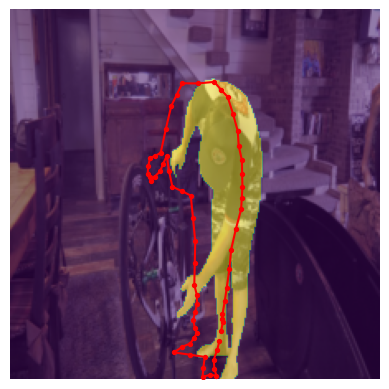

In [143]:
frame_idx = 5
img, gt_mask, gt_bou = val_dataset.raw_data_set[0][frame_idx]
infer_bou, infer_mask, infer_iou = infer_result[frame_idx]
np_bous = infer_bou.detach().cpu().numpy()
np_bou = np_bous[0]
np_bou.shape
plt.imshow(normalize(img).permute(1, 2, 0))
plt.plot(np_bou[:, 0], np_bou[:, 1], "r")
plt.scatter(np_bou[:, 0], np_bou[:, 1], c="r", s=8)
plt.imshow(gt_mask, alpha=0.5)
plt.axis("off")
plt.show()
